## Importing Required Libraries

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
from tensorflow.keras.optimizers import Adam
sns.set(style="darkgrid")

## Importing Amazon One Plus Data

In [8]:
file_path = r"/content/amazon_one_plus_reviews.json"
df = pd.read_json(file_path)

# Extract the numeric rating and convert to float
df['numeric_rating'] = df["review_rating"].str.extract(r'([0-9]+\.?[0-9]*)').astype(float)

# Function to convert ratings
def convert_rating(rating):
    if rating >= 4.0:
        return 'positive'
    elif rating == 3.0:
        return 'neutral'
    else:
        return 'negative'

# Apply the function to the rating column
df['categorical_rating'] = df['numeric_rating'].apply(convert_rating)

amazon_df = df[['categorical_rating', 'review_text']]
print(amazon_df.shape)
print(amazon_df['categorical_rating'].value_counts())
amazon_df.head()

(30612, 2)
positive    22504
neutral      4172
negative     3936
Name: categorical_rating, dtype: int64


,categorical_rating,review_text
0,positive,"\n Yea..pre-ordered on 28 July, got it on 4 A..."
1,positive,"\n Got it delivered yesterday , used for abou..."
2,positive,\n An amazing phone!
3,positive,\n Brilliant..
4,positive,\n I was skeptical about changing from One pl...


## Importing Iphone Data

In [9]:
file_path = r"/content/apple_iphone_11_reviews.json"
df = pd.read_json(file_path)

# Extract the numeric rating and convert to float
df['numeric_rating'] = df["review_rating"].str.extract(r'([0-9]+\.?[0-9]*)').astype(float)

# Function to convert ratings
def convert_rating(rating):
    if rating >= 4.0:
        return 'positive'
    elif rating == 3.0:
        return 'neutral'
    else:
        return 'negative'

# Apply the function to the rating column
df['categorical_rating'] = df['numeric_rating'].apply(convert_rating)

iphone_df = df[['categorical_rating', 'review_text']]
print(iphone_df.shape)
print(iphone_df['categorical_rating'].value_counts())
iphone_df.head()

(5010, 2)
positive    4451
negative     406
neutral      153
Name: categorical_rating, dtype: int64


,categorical_rating,review_text
0,neutral,NOTE:
1,negative,Very bad experience with this iPhone xr phone....
2,positive,Amazing phone with amazing camera coming from ...
3,negative,So I got the iPhone XR just today. The product...
4,positive,I've been an android user all my life until I ...


## Importing K8 Data

In [10]:
file_path = r"/content/K8 Reviews v0.2.csv"
df = pd.read_csv(file_path)
df = df.rename(columns={'review': 'review_text'})
df['categorical_rating'] = df['sentiment'].replace({1: 'positive', 0: 'negative'})
df['categorical_rating'] = df['categorical_rating'].astype(str)

k8_df = df[['categorical_rating', 'review_text']]
print(k8_df.shape)
print(k8_df['categorical_rating'].value_counts())
k8_df.head()

(14675, 2)
negative    7712
positive    6963
Name: categorical_rating, dtype: int64


,categorical_rating,review_text
0,positive,Good but need updates and improvements
1,negative,"Worst mobile i have bought ever, Battery is dr..."
2,positive,when I will get my 10% cash back.... its alrea...
3,positive,Good
4,negative,The worst phone everThey have changed the last...


## Merge All DFs

In [11]:
merged_df = pd.concat([amazon_df, iphone_df, k8_df], axis=0)

# Reset the index of the merged DataFrame, if needed
merged_df = merged_df.reset_index(drop=True)

print(merged_df['categorical_rating'].value_counts())
print(merged_df.shape)
merged_df.head()

positive    33918
negative    12054
neutral      4325
Name: categorical_rating, dtype: int64
(50297, 2)


,categorical_rating,review_text
0,positive,"\n Yea..pre-ordered on 28 July, got it on 4 A..."
1,positive,"\n Got it delivered yesterday , used for abou..."
2,positive,\n An amazing phone!
3,positive,\n Brilliant..
4,positive,\n I was skeptical about changing from One pl...


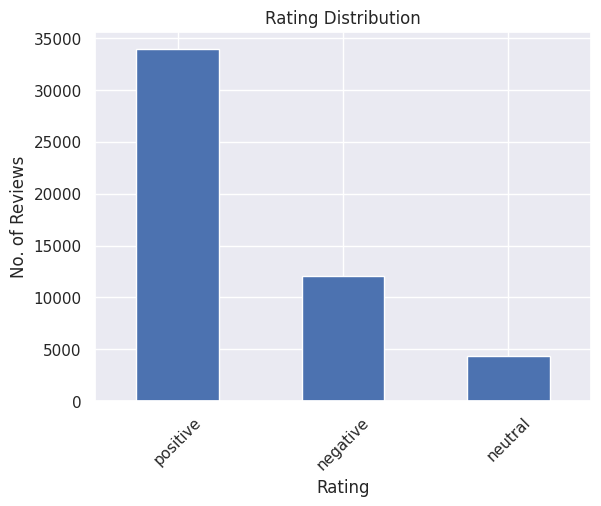

In [12]:


# Assuming 'merged_df' is your DataFrame with a 'categorical_rating' colum
# Plot the value counts as a bar plot
merged_df['categorical_rating'].value_counts().plot(kind='bar')

# Set the title and labels
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('No. of Reviews')

# Getting the categories from the 'categorical_rating' value counts
categories = merged_df['categorical_rating'].value_counts().index

# Set custom labels for the x-axis with rotation
plt.xticks(ticks=range(len(categories)), labels=categories, rotation=45)

# Show the plot
plt.show()


## Preparing Data for Model

In [14]:
# Step 1: Create X and y
X = df['review_text']
y = pd.get_dummies(df['categorical_rating'])  # Step 2: One-hot encode y

In [16]:
# Initial split: 80% for training, 20% for temporary dataset
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the temporary dataset equally into validation and test sets: 10% each of the original dataset
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

## Classification with BERT

In [17]:

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize and prepare the data for BERT
def encode_reviews(tokenizer, reviews, max_length):
    return tokenizer.batch_encode_plus(
        reviews,
        add_special_tokens=True,
        return_attention_mask=True,
        pad_to_max_length=True,
        max_length=max_length,
        truncation = True,
        return_tensors='tf',
    )

# Choose a maximum sequence length for BERT
max_length = 256

# Encode the datasets
train_encodings = encode_reviews(tokenizer, X_train.tolist(), max_length)
val_encodings = encode_reviews(tokenizer, X_val.tolist(), max_length)
test_encodings = encode_reviews(tokenizer, X_test.tolist(), max_length)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [19]:
from transformers import TFBertModel
from keras.layers import Input, Dense, Dropout
from keras.models import Model


# Load the pre-trained BERT model
bert = TFBertModel.from_pretrained('bert-base-uncased')

# Build the model
input_ids = Input(shape=(max_length,), dtype='int32', name='input_ids')
attention_masks = Input(shape=(max_length,), dtype='int32', name='attention_masks')

# Get the sequence output
sequence_output = bert(input_ids, attention_mask=attention_masks)[0]

# Select the first token's last hidden state
cls_token = sequence_output[:, 0, :]

# Add custom layers
x = Dense(512, activation='relu')(cls_token)
x = Dropout(0.1)(x)
x = Dense(256, activation='relu')(x)
output = Dense(y.shape[1], activation='softmax')(x)

# Compile the model
model = Model(inputs=[input_ids, attention_masks], outputs=output)

# Adjust the learning rate
optimizer = Adam(learning_rate=2e-5)

# Compile the model with the new optimizer
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

TypeError: Exception encountered when calling layer 'embeddings' (type TFBertEmbeddings).

Could not build a TypeSpec for name: "tf.debugging.assert_less_1/assert_less/Assert/Assert"
op: "Assert"
input: "tf.debugging.assert_less_1/assert_less/All"
input: "tf.debugging.assert_less_1/assert_less/Assert/Assert/data_0"
input: "tf.debugging.assert_less_1/assert_less/Assert/Assert/data_1"
input: "tf.debugging.assert_less_1/assert_less/Assert/Assert/data_2"
input: "Placeholder"
input: "tf.debugging.assert_less_1/assert_less/Assert/Assert/data_4"
input: "tf.debugging.assert_less_1/assert_less/y"
attr {
  key: "T"
  value {
    list {
      type: DT_STRING
      type: DT_STRING
      type: DT_STRING
      type: DT_INT32
      type: DT_STRING
      type: DT_INT32
    }
  }
}
attr {
  key: "summarize"
  value {
    i: 3
  }
}
 of unsupported type <class 'tensorflow.python.framework.ops.Operation'>.

Call arguments received by layer 'embeddings' (type TFBertEmbeddings):
  • input_ids=<KerasTensor: shape=(None, 256) dtype=int32 (created by layer 'input_ids')>
  • position_ids=None
  • token_type_ids=<KerasTensor: shape=(None, 256) dtype=int32 (created by layer 'tf.fill_1')>
  • inputs_embeds=None
  • past_key_values_length=0
  • training=False

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

model_save_path = r"D:\Marketing Paper\best_model_amazon_one.h5"

checkpoint = ModelCheckpoint(model_save_path, monitor='val_accuracy', save_best_only=True)

# Train the model
history = model.fit(
    [train_encodings['input_ids'], train_encodings['attention_mask']],
    y_train,
    validation_data=([
        val_encodings['input_ids'], val_encodings['attention_mask']
    ], y_val),
    epochs=5,
    batch_size=16,  # Specify your desired batch size here
    callbacks=[checkpoint]
)


In [ ]:
from tensorflow.keras.models import load_model

# Load the best model
best_model = load_model(model_save_path, custom_objects={'TFBertModel': TFBertModel})

# # Recompile the model with the optimizer, loss, and metrics
# model.compile(optimizer=Adam(learning_rate=2e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Evaluate the model on the test set
test_loss, test_acc = best_model.evaluate(
    [test_encodings['input_ids'], test_encodings['attention_mask']],
    y_test
)

print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

In [ ]:
# Assuming `test_encodings` is already prepared similar to `train_encodings` and `val_encodings`
predictions = best_model.predict([test_encodings['input_ids'], test_encodings['attention_mask']])


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix



# Assuming you have predictions from the model
predicted_class_indices = predictions.argmax(axis=1)

# Convert y_test from one-hot encoding to class indices
true_class_indices = y_test.idxmax(axis=1).apply(class_names.index).values



# Generate the classification report using the true and predicted class indices
report = classification_report(true_class_indices, predicted_class_indices, target_names=class_names)
print(report)

# Generate the confusion matrix
cm = confusion_matrix(true_class_indices, predicted_class_indices)

# Calculate accuracy for each class
class_accuracies = cm.diagonal() / cm.sum(axis=1)
for class_name, accuracy in zip(class_names, class_accuracies):
    print(f'Accuracy for class {class_name}: {accuracy:.2f}')